**Example 2.4:** Comparison of interpolation approaches for image shrinking and zooming.

> This code is written with Julia v1.0.0, Images v0.16.1

This example does the following things:
1. downsample the original 1250 dpi image into 75 dpi and 150 dpi
2. upsample the downsampled image to 1250 dpi with method of **nearest neighbor**, **bilinear** and **bicubic**, respectively.

For the sake of ease, I will do:
1. **Naive implementation**: Handwrite functions to do all the `imresize` work, which helps you understand how imresize works, hence I'll make this part of code as clear as possible and not consider implementation with better performance
2. **Optimized implementation**: Optimize the naive implementation for a faster speed
3. **Convolutional implementation**: resampling can be achieved by convolution with kernel
3. **Engineer implementation**: Give a better implementation using interface given by `Images`, more specifically, given by `ImageTransformations`

Some information:
* [TUTORIAL: IMAGE RESCALING](https://clouard.users.greyc.fr/Pantheon/experiments/rescaling/index-en.html#bilinear)

Todo:
* Implementation of bicubic
* Convolutional implementation

In [1]:
using Printf # format string in C style
using Images # core package for image

# Naive implementation
## 1.1 Nearest Neighbor Interpolation

最近邻插值的想法是，对于未知的像素值所在位置`(x,y)`，将最接近的已知像素值的位置`(x_old,y_old)`的像素值赋予它

以将`200*300`分辨率的图片放大1.5倍为例，为了计算出最接近的像素值位置，有两种实现方案：
1. 从未知的像素值所在位置`(x,y)`出发，计算出它缩小`1.5`倍之后的坐标`(x',y') = (x,y)/1.5`（这并非都是格点），然后在旧的坐标棋盘上通过`round`找到最接近的格点，将其值赋予新像素值`f_new(x,y) = f_old(round.(x',y'))`即可
2. 从已知的像素值所在位置`(x_old,y_old)`出发，计算出它放大1.5倍之后的坐标`(x_old',y_old')`，然后在新的坐标棋盘上找到未知像素值所在位置`(x,y)`最接近的点`(x_old',y_old')`，将其值赋予新像素值`f_new(x,y) = f_old(x_old',y_old')`即可

第一种方法找最近邻时只需要做round操作，而第二种方法则没有一个简单的实现方式，因此这里采用第一种方法

In [2]:
"""
    nearest_raw(img, sz)

use nearest neighbor interpolation to resize an image.

Nearest neighbor interpolation assign the value of the 'nearest' pixel to new pixels.
It is simple but might produce undesirable artifacts, such as severe distortion of straight edges.
"""
function nearest_raw(img, sz)
    ori_sz = size(img)
    length(ori_sz) == length(sz) || ArgumentError("Wrong sz")
    
    # you might wanna combine this three arrays into one to reduce memory usage
    pixels = [[x,y] for x in 1:sz[1], y in 1:sz[2]] # new image pixels
    pixels_ori = [ pixel .* ori_sz ./ sz for pixel in pixels] # new image pixels in original board
    # nearest pixels
    pixels_nearest = [ [clamp(round(Int, pixel[1]), 1, ori_sz[1]),
            clamp(round(Int, pixel[2]), 1, ori_sz[2])]
        for pixel in pixels_ori] # use clamp to make sure imdex is valid 
    
    dest_img = similar(img, sz...) # create a arrary with the same type of img, with size=sz
    for pixel in pixels
        nearest_pixel = pixels_nearest[pixel...]
        dest_img[pixel...] = img[nearest_pixel...]
    end
    return dest_img
end

nearest_raw

## 1.2 Bilinear Interpolation
双线性插值相比最近邻插值来说要稍微复杂一些，因为它不仅涉及到像素的坐标格点，还涉及到像素值

简单来说，对于每一个未知像素值所在位置`(x,y)`，双线性插值：
1. 像最近邻一样，找到它在原始图片中的坐标`(x',y')`（这未必是格点）
2. 最近邻将距离`(x',y')`仅仅将最近的（一个）坐标格点的像素值赋予`f_new(x,y)`。双线性插值考虑的是将上下左右四个格点的值以线性插值的方式赋予`f_new(x,y)`。
    1. `f_new_T = linear(f_old(TL), f_old(TR))` 利用左上与右上格点的像素值，计算出正上方坐标的像素值
    2. `f_new_B = linear(f_old(BL), f_old(BR))` 利用左下与右下格点的像素值，计算出正下方坐标的像素值
    3. `f_new = linear(f_new_T,f_new_B)` 利用正上方与正下方坐标的像素值，计算出中间`(x',y')`的像素值

双线性插值一共进行三次线性插值，线性插值采用如下等式：

$$f(x,y) = \frac{d((x_2,y_2),(x,y))}{d((x_1,y_1),(x_2,y_2))}\cdot f(x_1,y_1) + \frac{d((x_1,y_1),(x,y))}{d((x_1,y_1),(x_2,y_2))}\cdot f(x_2,y_2) $$

为了方便起见，定义一个新的Point类型，并写一个线性插值函数

In [3]:
mutable struct Point{T}
    value::T
    pos::AbstractArray
end
Base.copy(p::Point) = Point(copy(p.value),copy(p.pos))

In [4]:
# Define linear interpolation for bilinear
d(pos1,pos2) = abs2.(pos1-pos2) |> sum |> sqrt
function linear!(p::Point{T}, p1::Point{T}, p2::Point{T}) where T# This will change the value of p
    if p1.pos == p2.pos
        p.value = (p1.value+p2.value)/2
    else
        p.value = p1.value * T(d(p2.pos, p.pos)/d(p1.pos, p2.pos)) +
           p2.value * T(d(p1.pos, p.pos)/d(p1.pos, p2.pos))
    end
    return p
end
"""
    linear(p,p1,p2)

Linear interpolation of p with information of p1 and p2
"""
function linear(p::Point, p1::Point, p2::Point) # This will not change the value of p
    p_dest = copy(p)
    linear!(p_dest, p1, p2)
    return p_dest
end

linear

In [5]:
"""
    bilinear_raw(img,sz)

use bilinear interpolation to resize an image.
"""
function bilinear_raw(img, sz)
    ori_sz = size(img)
    length(ori_sz) == length(sz) || ArgumentError("Wrong sz")
    
    # the same procedure as nearest neighbor
    pixels = [[x,y] for x in 1:sz[1], y in 1:sz[2]] # new image pixels
    pixels_ori = [ pixel .* ori_sz ./ sz for pixel in pixels] # new image pixels in original board
    
    dest_img = similar(img, sz...) # create a arrary with the same type of img, with size=sz
    for pixel in pixels
        # get four near pixels
        pixel_ori = pixels_ori[pixel...]
        t = clamp(floor(Int, pixel_ori[1]), 1, ori_sz[1]) # x top
        b = clamp(ceil(Int, pixel_ori[1]), 1, ori_sz[1]) # x bottom
        l = clamp(floor(Int, pixel_ori[2]), 1, ori_sz[2]) # y left
        r = clamp(ceil(Int, pixel_ori[2]), 1, ori_sz[2]) # y right
        
        TL = [t,l]
        TR = [t,r]
        BL = [b,l]
        BR = [b,r]
        
        # do linear interpolation for three times
        T = [t, pixel_ori[2]] # top
        B = [b, pixel_ori[2]] # bottom
        Point_T = linear(
            Point(img[TL...],T),
            Point(img[TL...],TL),
            Point(img[TR...],TR))
        Point_B = linear(
            Point(img[BL...],B),
            Point(img[BL...],BL),
            Point(img[BR...],BR))
        Point_p = linear(
            Point(dest_img[pixel...],pixel_ori),
            Point_T, Point_B)
        
        dest_img[pixel...] = Point_p.value
    end
    return dest_img
end

bilinear_raw

## 1.3 Bicubic Interpolation

In [6]:
function bicubic_raw
end

bicubic_raw (generic function with 0 methods)

Let's show the results now
1. downsample the original image into 150 dpi and 72 dpi

summary(ori_img) = "3692×2812 Array{Gray{Float32},2} with eltype Gray{Float32}"


,

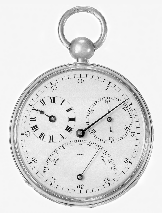
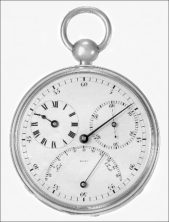

In [7]:
ori_img = load("Data/Fig0220(a).tif") .|> float32 # use Float32 to avoid unwanted overflow in N0f8
@show summary(ori_img)

ori_dpi = 1250
dpis = [72, 150]
# make sure to add round.(Int, sz), otherwise it will throw StackOverflow Error
szs = [round.(Int, size(ori_img) .* dpi ./ ori_dpi) for dpi in dpis] 

src_imgs = [imresize(ori_img, sz) for sz in szs]

2. upsample to original resolution

 29.396687 seconds (136.15 M allocations: 4.801 GiB, 46.45% gc time)
 31.821796 seconds (135.38 M allocations: 4.763 GiB, 41.04% gc time)
119.814291 seconds (1.29 G allocations: 48.616 GiB, 10.82% gc time)
119.704528 seconds (1.29 G allocations: 48.795 GiB, 10.15% gc time)


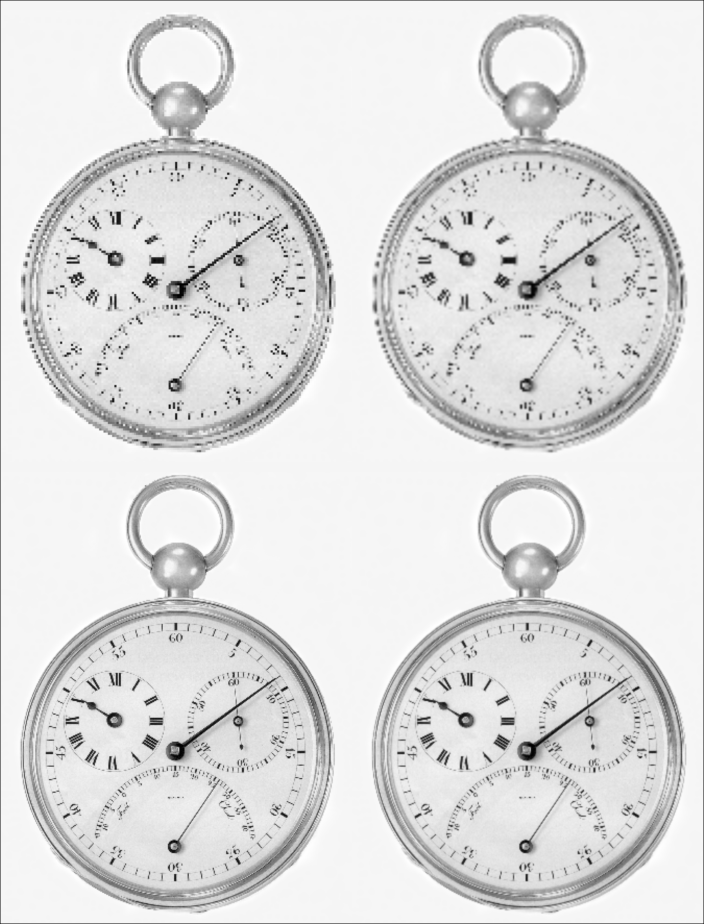

In [8]:
nearest(img,sz) = nearest_raw(img,sz)
bilinear(imgs,sz) = bilinear_raw(imgs,sz)

imgs_nearest = [@time nearest(img,size(ori_img)) for img in src_imgs] # takes 30 seconds
imgs_bilinear = [@time bilinear(img,size(ori_img)) for img in src_imgs] # takes almost 2-min

hcat(vcat(imgs_nearest...),
    vcat(imgs_bilinear...))

# Optimized imresize
I made following steps to do performance optimization:
1. remove unnecessary conversion
2. remove unncessary allocation

Although, this by no means is a good implementation.

In [9]:
function nearest_fast(img::Array{T}, sz) where T
    ori_sz = size(img)
    length(ori_sz) == length(sz) || ArgumentError("Wrong sz")
    
    dest_img = similar(img,sz...) # create a arrary with the same type of img, with size=sz
    ratio = ori_sz./sz
    for i in 1:sz[1], j in 1:sz[2]
        dest_img[i,j] = img[clamp(round(Int, i * ratio[1]), 1, ori_sz[1]),
            clamp(round(Int, j * ratio[2]), 1, ori_sz[2])]
    end
    return dest_img
end

nearest_fast (generic function with 1 method)

In [10]:
function bilinear_fast(img::T, sz)::T where T
    ori_sz = size(img)
    length(ori_sz) == length(sz) || ArgumentError("Wrong sz")

    ratio = ori_sz ./ sz
    dest_img = similar(img,sz...) # create a arrary with the same type of img, with size=sz
    for i in 1:sz[1], j in 1:sz[2]
        x,y = [i,j].*ratio
        t = clamp(floor(Int, x), 1, ori_sz[1]) # x top
        b = clamp(ceil(Int, x), 1, ori_sz[1]) # x bottom
        l = clamp(floor(Int, y), 1, ori_sz[2]) # y left
        r = clamp(ceil(Int, y), 1, ori_sz[2]) # y right
        
        if [b,r] == [t,l]
            dest_img[i,j] = img[t,l]
            continue
        end
        
        if b == t
            dest_img[i,j] = ((y-l)img[b,r]+(r-y)img[b,l])/(r-l)
            continue
        end
        
        if r == l
            dest_img[i,j] = ((x-t)img[b,l]+(b-x)img[t,l])/(b-t)
            continue
        end

        dest_img[i,j] = ((b-x)*(r-y)*img[t,l] +
            (x-t)*(r-y)*img[b,l] +
            (b-x)*(y-l)*img[t,r] +
            (x-t)*(y-l)*img[b,r]) / ((b-t)*(r-l))
    end
    return dest_img
end

bilinear_fast (generic function with 1 method)

Test the optimized version

  0.193657 seconds (88.00 k allocations: 44.172 MiB, 20.20% gc time)
  0.220234 seconds (3 allocations: 39.604 MiB, 73.57% gc time)
  3.822631 seconds (59.28 M allocations: 4.026 GiB, 21.81% gc time)
  3.525041 seconds (58.97 M allocations: 4.011 GiB, 20.23% gc time)


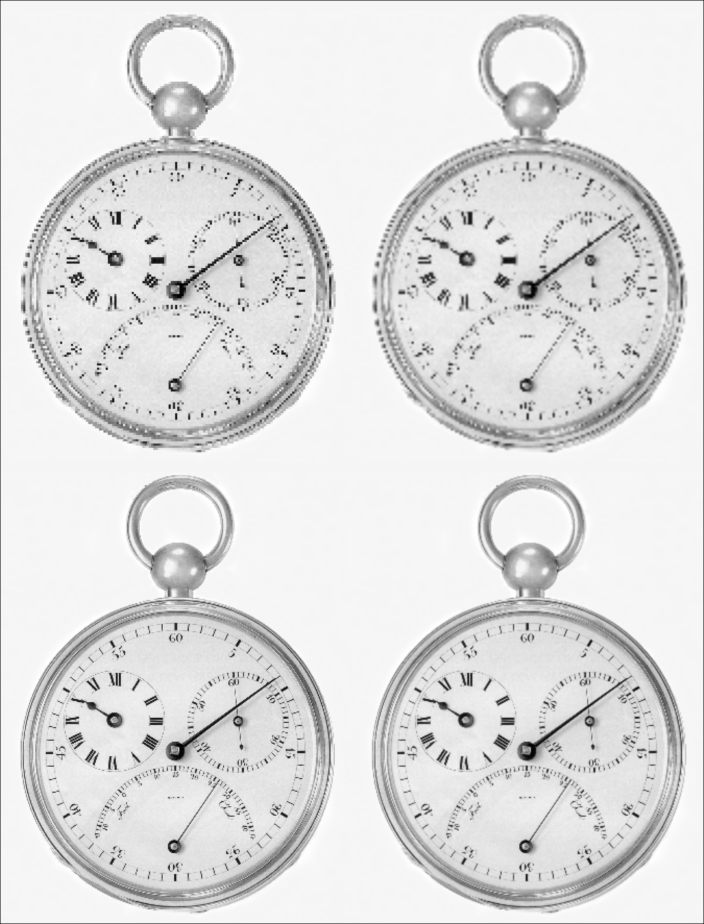

In [11]:
ori_img = load("Data/Fig0220(a).tif") .|> float32
ori_dpi = 1250
dpis = [72, 150]
szs = [round.(Int, size(ori_img) .* dpi ./ ori_dpi) for dpi in dpis] 
src_imgs = [imresize(ori_img, sz) for sz in szs]

nearest(img,sz) = nearest_fast(img,sz)
bilinear(img,sz) = bilinear_fast(img,sz)

imgs_nearest = [@time nearest(img, size(ori_img)) for img in src_imgs] # takes 0.2 seconds
imgs_bilinear = [@time bilinear(img,size(ori_img)) for img in src_imgs] # takes 4.8 seconds

hcat(vcat(imgs_nearest...),
    vcat(imgs_bilinear...))

# Engineer Implementation

目前 `Images`包中的`imresize`仅仅只支持双线性插值，并且不能够传入参数。不过`imresize!`包可以传入`AbstractInterpolation`类型[check here](https://github.com/JuliaImages/ImageTransformations.jl/blob/ad989aa1b7b8c960757c2e5809f398211ac64580/src/resizing.jl#L243)，所以可以使用`Interpolations`包提供的工具来做这一操作

Note:
This part of work might be unncessary if `Images` give support to `interpolation_type` argument, see [#51](https://github.com/JuliaImages/ImageTransformations.jl/issues/51)

In [12]:
using Interpolations, ImageTransformations

function imresize_interpolate(img::AbstractArray{S,N}, method::String) where {S,N}
    if method == "nearest"
        return interpolate(img, BSpline(Constant()))
    end
    if method == "bilinear"
        return interpolate(img, BSpline(Linear()))
    end
    if method == "bicubic"
        return interpolate(img, BSpline(Cubic(Line(OnGrid()))))
    end
end

function ImageTransformations.imresize!(resized::AbstractArray{T,N}, original::AbstractArray{S,N}, method::String) where {T,S,N}
    ImageTransformations.imresize!(resized, imresize_interpolate(original,method))
end

function ImageTransformations.imresize(original::AbstractArray{T,N}, new_size::Dims{N}, method::String) where {T,N}
    ImageTransformations.imresize!(similar(original, new_size), original, method)
end

  1.550528 seconds (455.15 k allocations: 63.119 MiB, 0.95% gc time)
  0.148477 seconds (6 allocations: 40.174 MiB, 5.50% gc time)
  0.215318 seconds (1.08 k allocations: 39.793 MiB, 11.36% gc time)
  0.293431 seconds (6 allocations: 40.174 MiB, 37.35% gc time)
  2.874295 seconds (2.45 M allocations: 149.672 MiB, 13.83% gc time)
  0.559269 seconds (197 allocations: 42.654 MiB, 3.22% gc time)


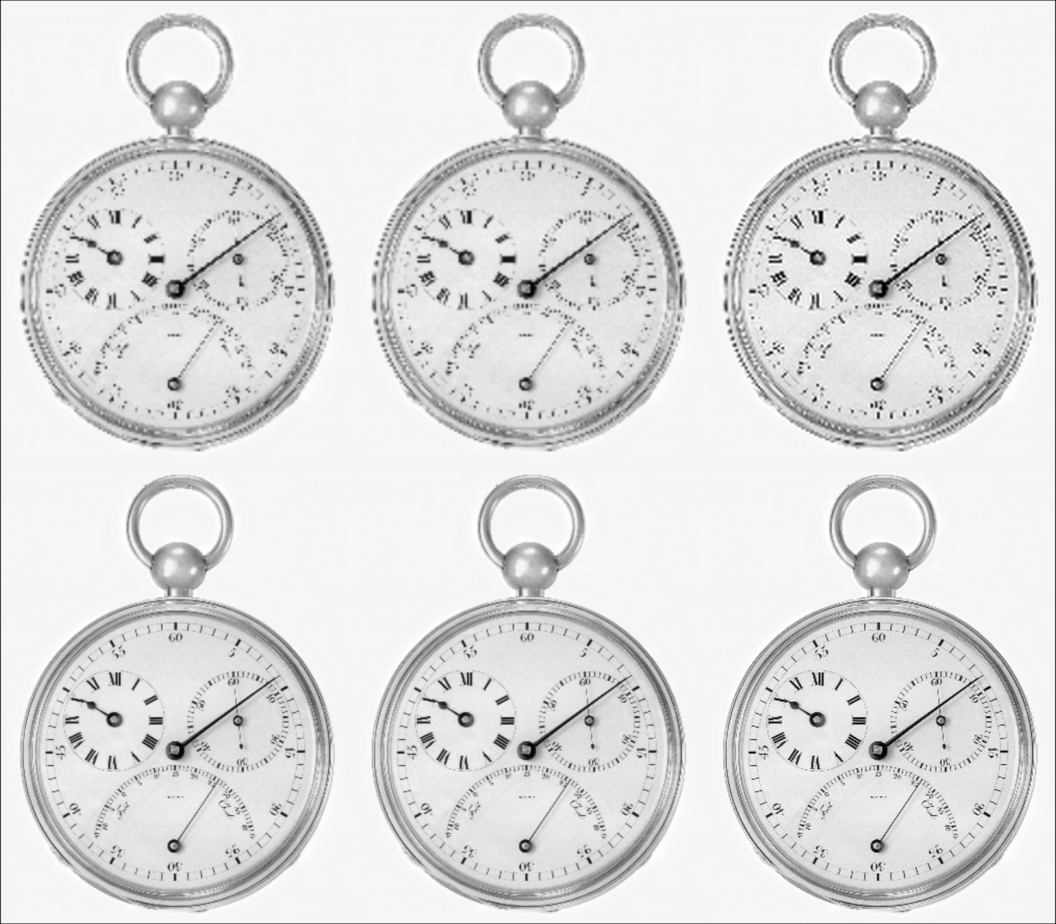

In [13]:
ori_img = load("Data/Fig0220(a).tif") .|> float32
ori_dpi = 1250
dpis = [72, 150]
szs = [round.(Int, size(ori_img) .* dpi ./ ori_dpi) for dpi in dpis] 
src_imgs = [imresize(ori_img, sz) for sz in szs]

nearest(img,sz) = imresize(img,sz,"nearest")
bilinear(img,sz) = imresize(img,sz,"bilinear")
bicubic(img,sz) = imresize(img,sz,"bicubic")

imgs_nearest = [@time nearest(img, size(ori_img)) for img in src_imgs]
imgs_bilinear = [@time bilinear(img, size(ori_img)) for img in src_imgs]
imgs_bicubic = [@time bicubic(img, size(ori_img)) for img in src_imgs]

hcat(vcat(imgs_bilinear...),
    vcat(imgs_bilinear...),
    vcat(imgs_bicubic...))